Worked with:
- Trevor Mathisen

- Viet Nguyen

1. Download startup failure dataset and its description.
2. Perform standard EDA to get familiar with the dataset.

In [1]:
from sklearn.model_selection import KFold, cross_val_score
from numpy import set_printoptions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import re
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve


In [1]:
import os
dfs = []
for dirname, _, filenames in os.walk('datasets'):
    for filename in filenames:
        if '(' in filename and 'Food' not in filename:
            print(f'Loading {filename}...')
            df_temp = pd.read_csv(f'datasets/{filename}', encoding='utf-8')
            print(df_temp.shape)
            dfs.append(df_temp)

data = pd.concat(dfs, ignore_index=True)
set_printoptions(precision=3)
data = data.dropna()
print(data.isnull().sum())
print(data.shape)
# Display unique values in each column
for col in data.columns:
    unique_values = data[col].unique()
    print(f"Unique values in '{col}': {unique_values}")


Loading Startup Failure (Manufactures).csv...


NameError: name 'pd' is not defined

In [3]:
data = data.drop(columns=['Name', 'What They Did', 'Why They Failed', 'Takeaway'])
data['Overhype'] = data['Overhype'].astype(int)
binary_columns = ['Giants', 'No Budget', 'Competition', 'Poor Market Fit', 'Acquisition Stagnation', 'Platform Dependency', 'Monetization Failure', 'Niche Limits', 'Execution Flaws', 'Trend Shifts', 'Toxicity/Trust Issues', 'Regulatory Pressure', 'Overhype']
print(data.head(5))

          Sector Years of Operation How Much They Raised  Giants  No Budget  \
0  Manufacturing          2011-2018                 $70M       1          1   
1  Manufacturing          2010-2019                $200M       1          1   
2  Manufacturing          2005-2011                 $40M       1          0   
3  Manufacturing          2008-2019                 $39M       1          0   
4  Manufacturing          2012-2017                 $73M       1          0   

   Competition  Poor Market Fit  Acquisition Stagnation  Platform Dependency  \
0            1                0                       0                    0   
1            1                0                       0                    0   
2            1                1                       0                    0   
3            1                1                       0                    0   
4            1                0                       1                    0   

   Monetization Failure  Niche Limits  Execu

In [4]:
def parse_years(row):
    years_str = str(row)
    # Case 1: Format like "6 (2011-2017)"
    if '(' in years_str and ')' in years_str:
        lifespan = re.search(r'(\d+)\s*\(', years_str)
        founded = re.search(r'\((\d+)-', years_str)
        shutdown = re.search(r'-(\d+)\)', years_str)
        return (int(lifespan.group(1)) if lifespan else np.nan,
                int(founded.group(1)) if founded else np.nan,
                int(shutdown.group(1)) if shutdown else np.nan)
    # Case 2: Format like "2011-2017"
    elif '-' in years_str and '(' not in years_str:
        match = re.search(r'(\d+)-(\d+)', years_str)
        if match:
            founded, shutdown = int(match.group(1)), int(match.group(2))
            lifespan = shutdown - founded
            return lifespan, founded, shutdown
    return np.nan, np.nan, np.nan

# First create temporary columns for years
years_data = data['Years of Operation'].apply(parse_years).apply(pd.Series)
years_data.columns = ['Years of Operation', 'start_year', 'end_year']

# Update the dataframe with the parsed values
data['Years of Operation'] = years_data['Years of Operation']
# data['start_year'] = years_data['start_year']
# data['end_year'] = years_data['end_year']

In [5]:
# Clean Funding: Convert 'How Much They Raised' to numeric values in millions ($M)
def clean_funding(x):
    if pd.isna(x): return 0
    match = re.search(r'\$(\d*\.?\d+)([MB])', x)
    if match:
        value, unit = float(match.group(1)), match.group(2)
        return value * 1000 if unit == 'B' else value  # Convert billions to millions
    return 0
data['Funding ($M)'] = data['How Much They Raised'].apply(clean_funding)
data = data.drop(columns=['How Much They Raised'])

print(data.head(5))

          Sector  Years of Operation  Giants  No Budget  Competition  \
0  Manufacturing                   7       1          1            1   
1  Manufacturing                   9       1          1            1   
2  Manufacturing                   6       1          0            1   
3  Manufacturing                  11       1          0            1   
4  Manufacturing                   5       1          0            1   

   Poor Market Fit  Acquisition Stagnation  Platform Dependency  \
0                0                       0                    0   
1                0                       0                    0   
2                1                       0                    0   
3                1                       0                    0   
4                0                       1                    0   

   Monetization Failure  Niche Limits  Execution Flaws  Trend Shifts  \
0                     0             0                0             0   
1                   

## There's no need to perform this on the other numeric columns as they are binary and no distribution transformation is needed.

       Funding ($M)  Years of Operation
count    382.000000          382.000000
mean     161.022971            7.575916
std      394.164114            3.556554
min        0.000000            0.000000
25%        5.000000            5.000000
50%       29.250000            7.000000
75%      121.625000           10.000000
max     3600.000000           18.000000


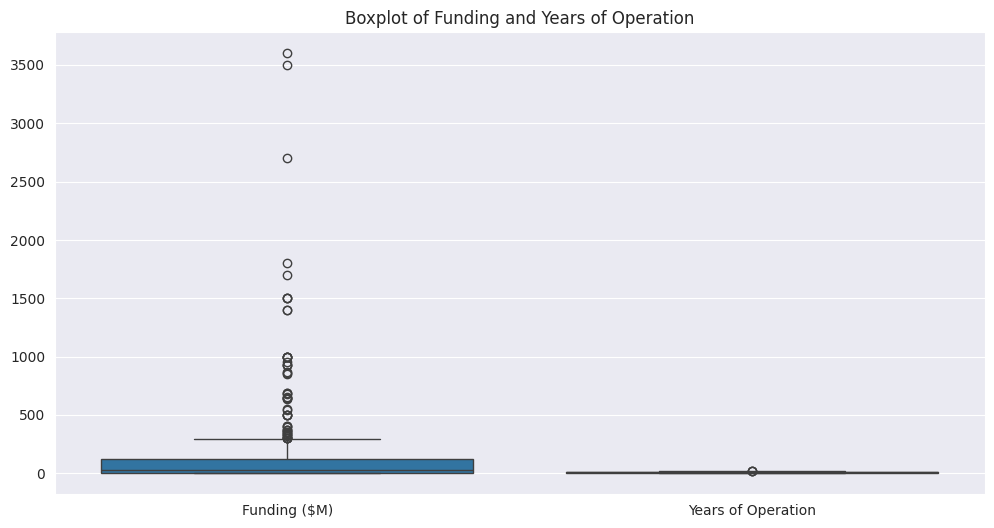

Skewness of Funding: 5.159243939703619
Skewness of Years of Operation: 0.6276991129508875


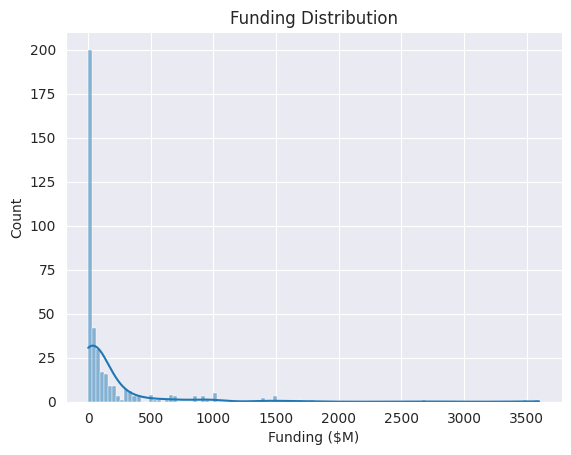

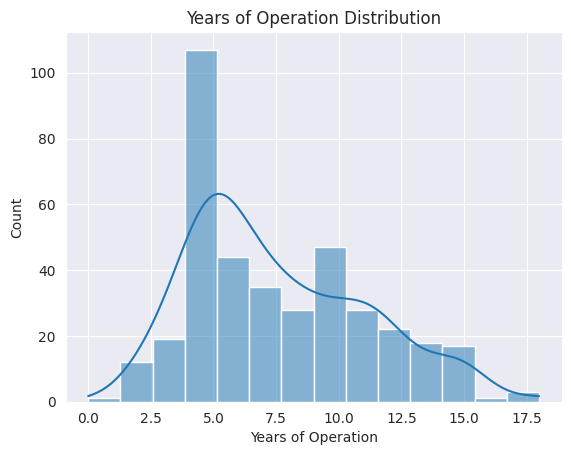

In [6]:
# Statistics on Funding and Years of Operation to determine if we need to normalize or standardize or nothing
print(data[['Funding ($M)', 'Years of Operation']].describe())
# Check for outliers in Funding and Years of Operation
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[['Funding ($M)', 'Years of Operation']])
plt.title('Boxplot of Funding and Years of Operation')
plt.show()
# Check for skewness
print("Skewness of Funding:", data['Funding ($M)'].skew())
print("Skewness of Years of Operation:", data['Years of Operation'].skew())
# Check for normality
sns.histplot(data['Funding ($M)'], kde=True)
plt.title('Funding Distribution')
plt.xlabel('Funding ($M)')
plt.show()
sns.histplot(data['Years of Operation'], kde=True)
plt.title('Years of Operation Distribution')
plt.xlabel('Years of Operation')
plt.show()

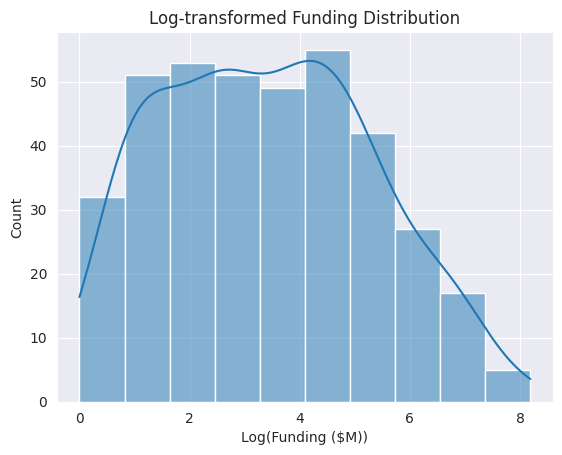

In [7]:
# Log transform funding, years of operation is fine
data['Funding ($M)'] = np.log1p(data['Funding ($M)'])
# Now show the distribution again
sns.histplot(data['Funding ($M)'], kde=True)
plt.title('Log-transformed Funding Distribution')
plt.xlabel('Log(Funding ($M))')
plt.show()

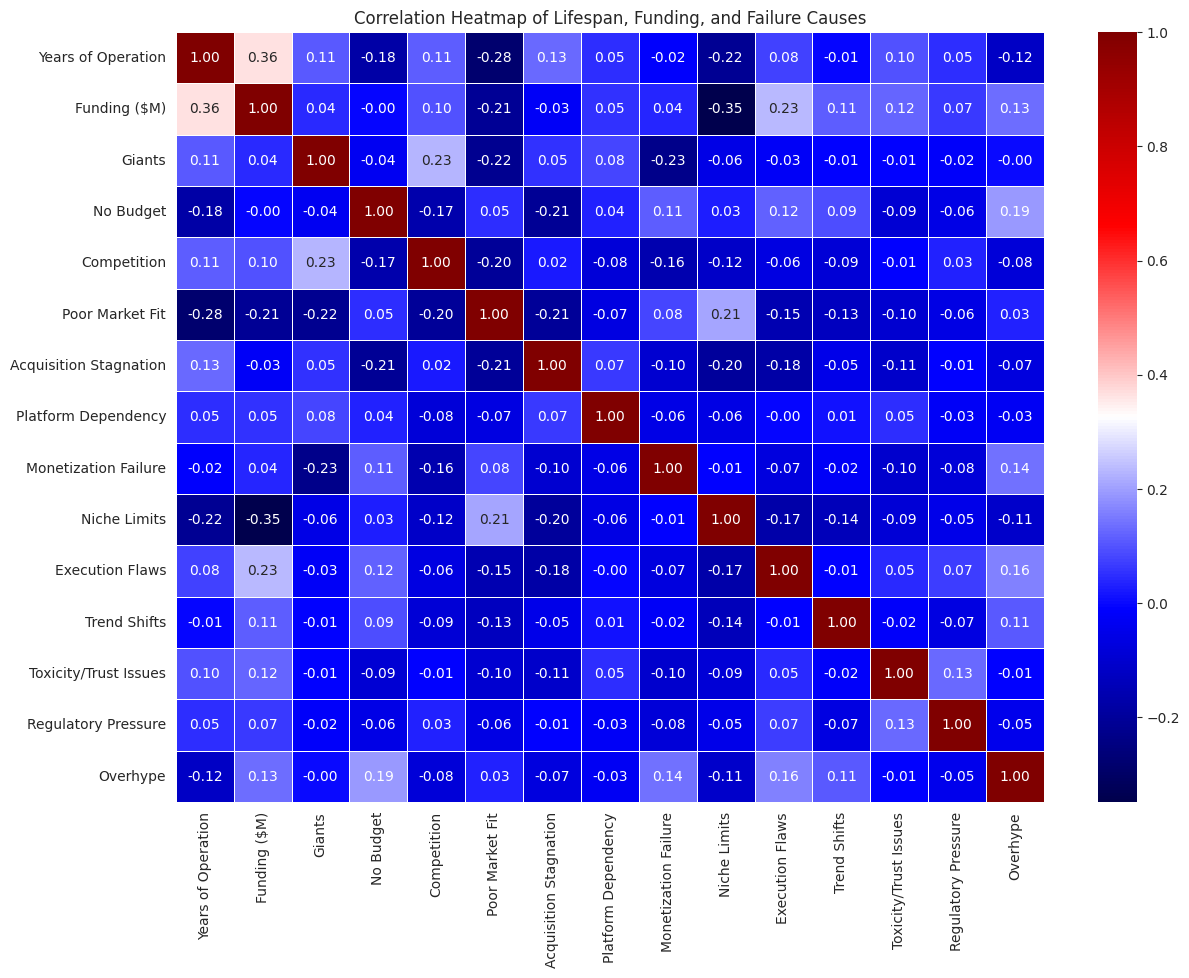

In [8]:
# Select columns for correlation
corr_cols = ['Years of Operation', 'Funding ($M)'] + binary_columns
corr_matrix = data[corr_cols].corr()
# Generate Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='seismic', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Lifespan, Funding, and Failure Causes')
plt.show()

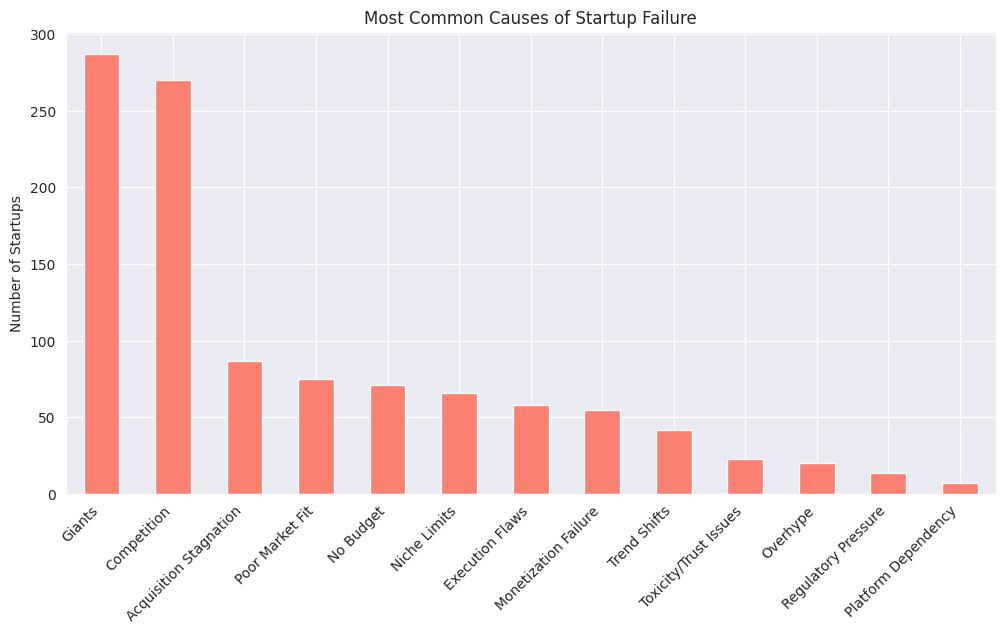

In [9]:
failure_sums = data[binary_columns].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
failure_sums.plot(kind='bar', color='salmon')
plt.title('Most Common Causes of Startup Failure')
plt.ylabel('Number of Startups')
plt.xticks(rotation=45, ha='right')
plt.show()


In [10]:
print(data.columns)
# Show unique data types within each column
for col in data.columns:
    unique_types = data[col].apply(type).unique()
    print(f"Unique data types in '{col}': {unique_types}")

Index(['Sector', 'Years of Operation', 'Giants', 'No Budget', 'Competition',
       'Poor Market Fit', 'Acquisition Stagnation', 'Platform Dependency',
       'Monetization Failure', 'Niche Limits', 'Execution Flaws',
       'Trend Shifts', 'Toxicity/Trust Issues', 'Regulatory Pressure',
       'Overhype', 'Funding ($M)'],
      dtype='object')
Unique data types in 'Sector': [<class 'str'>]
Unique data types in 'Years of Operation': [<class 'int'>]
Unique data types in 'Giants': [<class 'int'>]
Unique data types in 'No Budget': [<class 'int'>]
Unique data types in 'Competition': [<class 'int'>]
Unique data types in 'Poor Market Fit': [<class 'int'>]
Unique data types in 'Acquisition Stagnation': [<class 'int'>]
Unique data types in 'Platform Dependency': [<class 'int'>]
Unique data types in 'Monetization Failure': [<class 'int'>]
Unique data types in 'Niche Limits': [<class 'int'>]
Unique data types in 'Execution Flaws': [<class 'int'>]
Unique data types in 'Trend Shifts': [<class 'int

In [11]:
one_hot = pd.get_dummies(data['Sector'], prefix='Sector', dtype=int)
data = pd.concat([data, one_hot], axis=1)
data = data.drop(columns=['Sector'])
print(data.columns)
print(data.head(5))

Index(['Years of Operation', 'Giants', 'No Budget', 'Competition',
       'Poor Market Fit', 'Acquisition Stagnation', 'Platform Dependency',
       'Monetization Failure', 'Niche Limits', 'Execution Flaws',
       'Trend Shifts', 'Toxicity/Trust Issues', 'Regulatory Pressure',
       'Overhype', 'Funding ($M)', 'Sector_Finance and Insurance',
       'Sector_Health Care', 'Sector_Information', 'Sector_Manufacturing',
       'Sector_Retail Trade'],
      dtype='object')
   Years of Operation  Giants  No Budget  Competition  Poor Market Fit  \
0                   7       1          1            1                0   
1                   9       1          1            1                0   
2                   6       1          0            1                1   
3                  11       1          0            1                1   
4                   5       1          0            1                0   

   Acquisition Stagnation  Platform Dependency  Monetization Failure  \
0        

3. Use the sample code for the Ensemble classifier and modify it to work with the Startup
dataset.

In [12]:
# print(data.columns)
# output_variable = 'Years of Operation' # Accuracy = 0.2
# output_variable = 'Funding ($M)' # Accuracy = unable, regression problem
# output_variable = 'Overhype' # Accuracy = 0.96
# output_variable = 'Poor Market Fit' # Accuracy = 0.86
# output_variable = 'Execution Flaws' # Accuracy = 0.81
# Going to just plot all of them
# X = data.drop(output_variable, axis=1)
# Y = data[output_variable]
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

results = {}

for output_variable in binary_columns:
    # Skip if this column has already been evaluated
    if output_variable in results:
        continue

    X = data.drop(output_variable, axis=1)
    y = data[output_variable]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize models
    bag_clf = BaggingClassifier(
        DecisionTreeClassifier(random_state=42), n_estimators=500,
        bootstrap=True, n_jobs=-1, random_state=40)

    dt_clf = DecisionTreeClassifier(random_state=42)

    rf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)

    ab_clf = AdaBoostClassifier(
        DecisionTreeClassifier(random_state=42), n_estimators=500,
        learning_rate=1.0, random_state=42)

    # Train and evaluate
    models = {
        'Bagging': bag_clf,
        'Decision Tree': dt_clf,
        'Random Forest': rf_clf,
        'AdaBoost': ab_clf
    }

    output_results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        output_results[name] = accuracy

    results[output_variable] = output_results
    print(f"Completed evaluation for: {output_variable}, Best accuracy: {max(output_results.values()):.4f}")

# Convert the results to a DataFrame for easier visualization
results_df = pd.DataFrame(results)

Completed evaluation for: Giants, Best accuracy: 0.8442
Completed evaluation for: No Budget, Best accuracy: 0.8442
Completed evaluation for: Competition, Best accuracy: 0.8182
Completed evaluation for: Poor Market Fit, Best accuracy: 0.8571
Completed evaluation for: Acquisition Stagnation, Best accuracy: 0.7532
Completed evaluation for: Platform Dependency, Best accuracy: 0.9870
Completed evaluation for: Monetization Failure, Best accuracy: 0.8831
Completed evaluation for: Niche Limits, Best accuracy: 0.8182
Completed evaluation for: Execution Flaws, Best accuracy: 0.8182
Completed evaluation for: Trend Shifts, Best accuracy: 0.8961
Completed evaluation for: Toxicity/Trust Issues, Best accuracy: 0.9610
Completed evaluation for: Regulatory Pressure, Best accuracy: 0.9740
Completed evaluation for: Overhype, Best accuracy: 0.9740


<Figure size 1400x800 with 0 Axes>

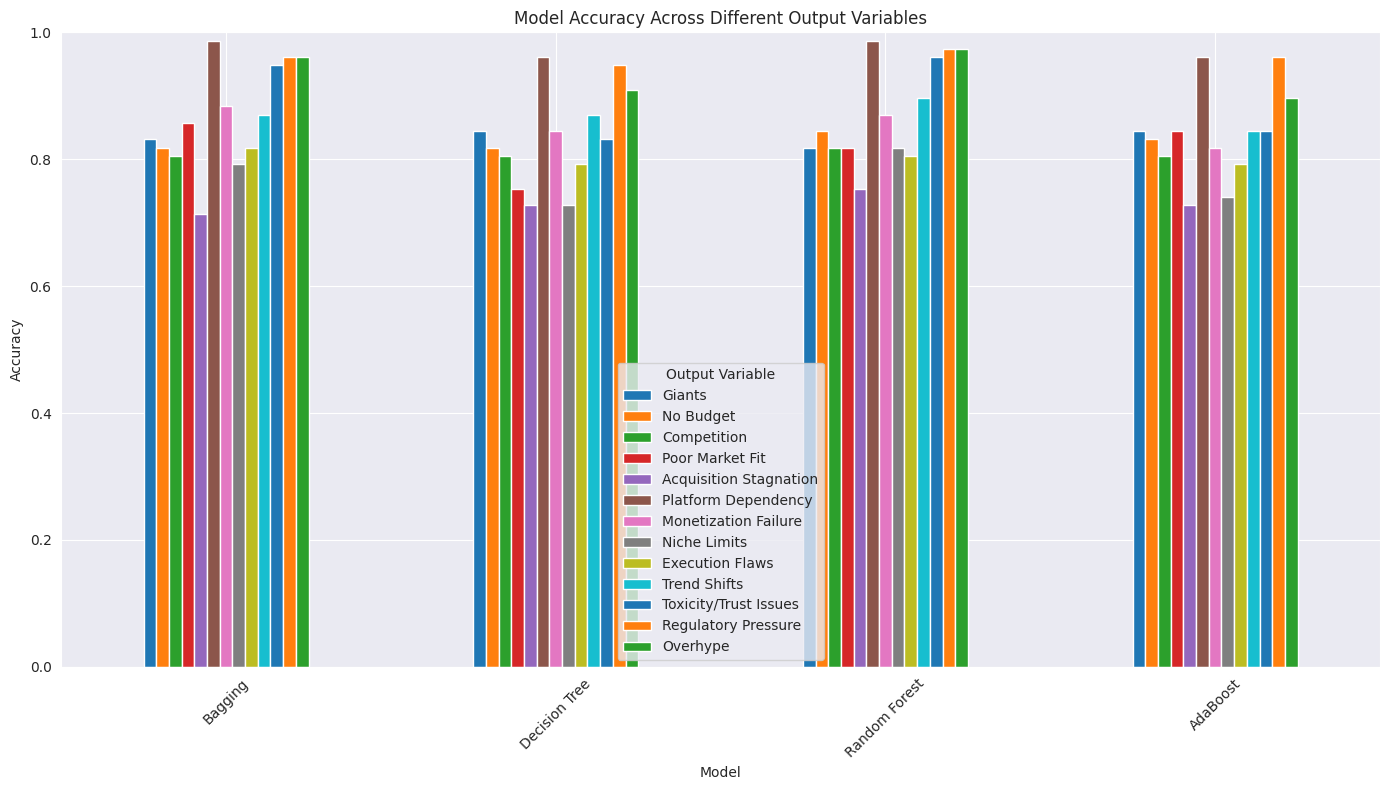

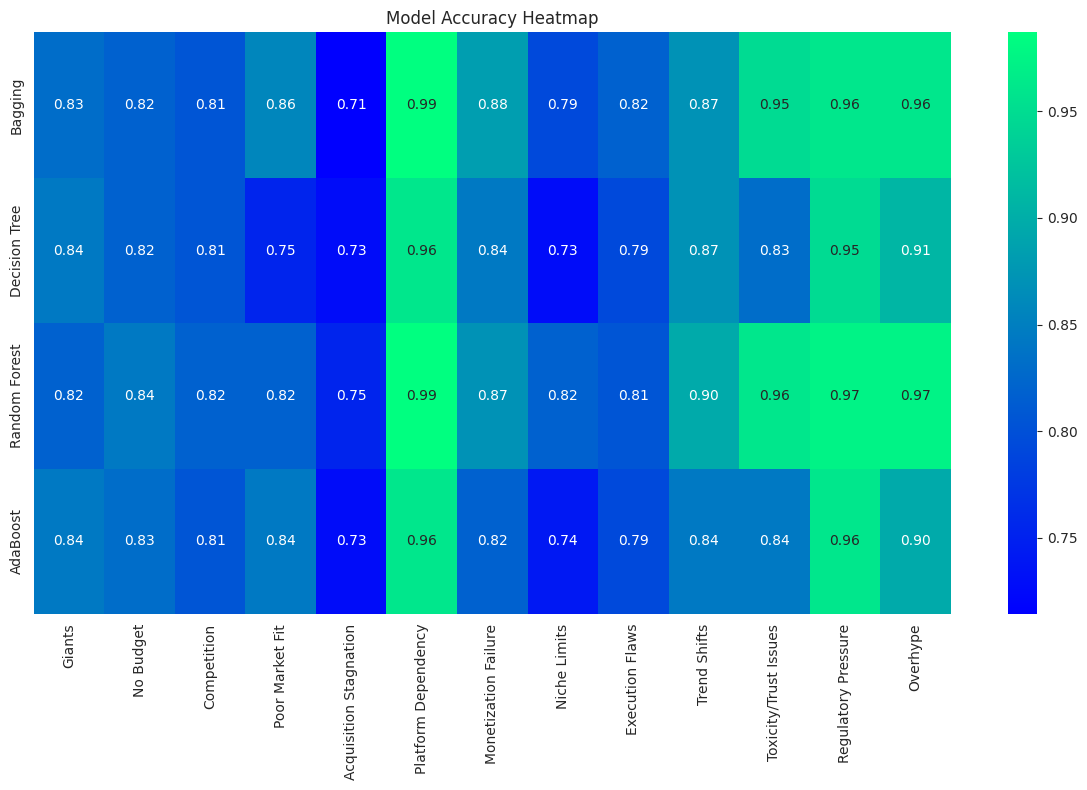

In [13]:
# Plotting
plt.figure(figsize=(14, 8))
results_df.plot(kind='bar', figsize=(14, 8))
plt.title('Model Accuracy Across Different Output Variables')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(title='Output Variable')
plt.tight_layout()
plt.show()

# Also create a heatmap for better visualization
plt.figure(figsize=(12, 8))
sns.heatmap(results_df, annot=True, cmap='winter', fmt='.2f')
plt.title('Model Accuracy Heatmap')
plt.tight_layout()
plt.show()

4. Compare the performance a decision tree, bagging classifier, random forest and a
boosting classifier using all default settings and configuration used in the sample code.

### Using 'Overhype' as the output variable to create an Overhype predictor. Overhype is a good candidate as it produces accurate classifiers, and has very low counts in the above EDA. By taking in the other features we can accurately predict if a startup is overhyped and therefore should not receive additional funding.

Bagging Classifier Accuracy: 0.9610
Decision Tree Classifier Accuracy: 0.9091
Random Forest Classifier Accuracy: 0.9740
AdaBoost Classifier Accuracy: 0.8961


/tmp/ipykernel_13824/3984243505.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=methods, y=accuracies, palette="viridis")


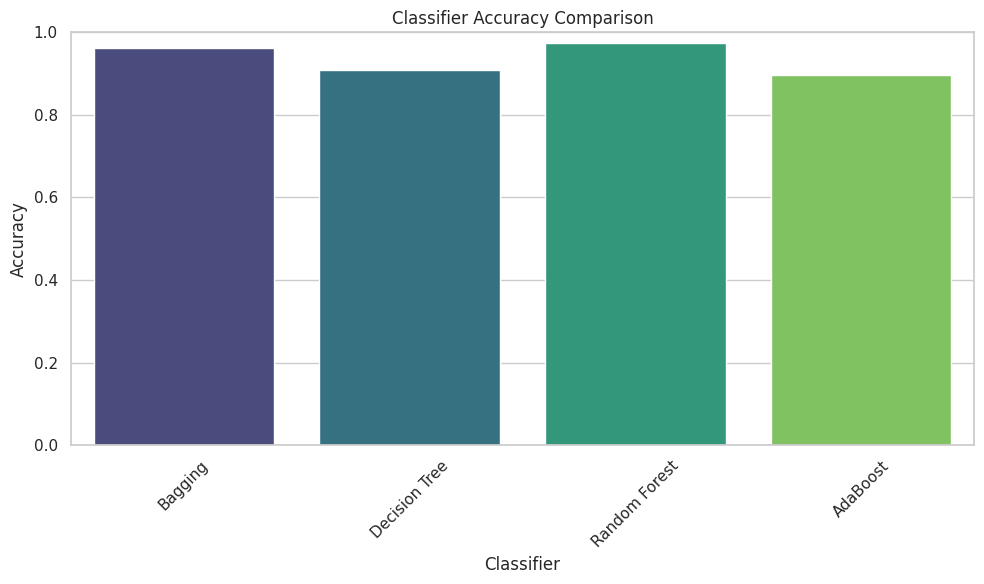

In [14]:
output_variable = 'Overhype'
X = data.drop(output_variable, axis=1)
Y = data[output_variable]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, random_state=40)
bag_clf.fit(X_train, Y_train)
bag_y_pred = bag_clf.predict(X_test)


dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, Y_train)
dt_y_pred = dt_clf.predict(X_test)

rf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rf_clf.fit(X_train, Y_train)
rf_y_pred = rf_clf.predict(X_test)
rf_y_prob = rf_clf.predict_proba(X_test)

ab_clf = AdaBoostClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    learning_rate=1.0, random_state=42)
ab_clf.fit(X_train, Y_train)
ab_y_pred = ab_clf.predict(X_test)

models_to_compare_in_step_7 = {
    'Bagging': bag_clf,
    'Decision Tree': dt_clf,
    'Random Forest': rf_clf,
    'AdaBoost': ab_clf
}

# Calculate and plot the accuracy scores
bag_accuracy = accuracy_score(Y_test, bag_y_pred)
dt_accuracy = accuracy_score(Y_test, dt_y_pred)
rf_accuracy = accuracy_score(Y_test, rf_y_pred)
ab_accuracy = accuracy_score(Y_test, ab_y_pred)
print(f"Bagging Classifier Accuracy: {bag_accuracy:.4f}")
print(f"Decision Tree Classifier Accuracy: {dt_accuracy:.4f}")
print(f"Random Forest Classifier Accuracy: {rf_accuracy:.4f}")
print(f"AdaBoost Classifier Accuracy: {ab_accuracy:.4f}")


sns.set(style="whitegrid")
# Data for plotting
methods = ['Bagging', 'Decision Tree', 'Random Forest', 'AdaBoost']
accuracies = [bag_accuracy, dt_accuracy, rf_accuracy, ab_accuracy]

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=methods, y=accuracies, palette="viridis")
plt.title('Classifier Accuracy Comparison')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


5. Modify the random forest classifier tree depth hyper-parameter for the depth of 2-7 and analyze and comment on the results of the impact of changing the tree depth on the performance (replace the max_leaf_nodes=16 with max_depth = 2 (change from 2-7) ).

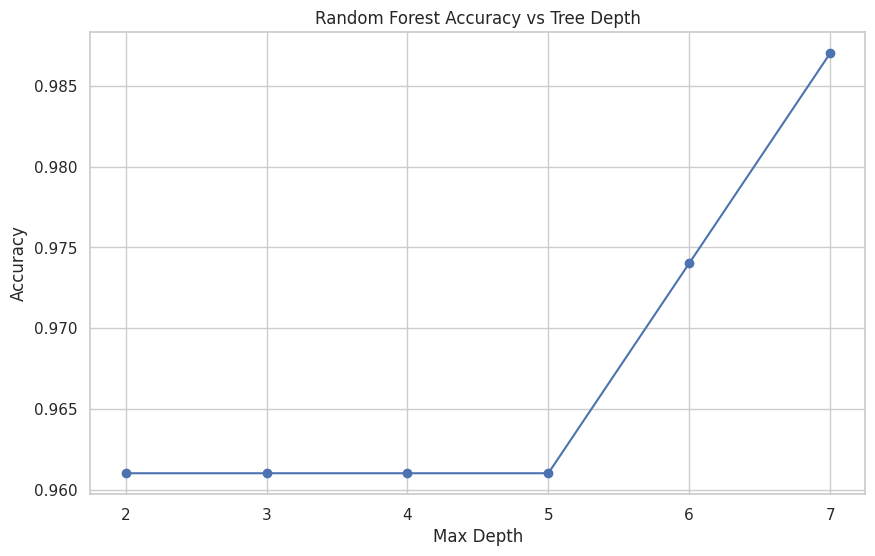

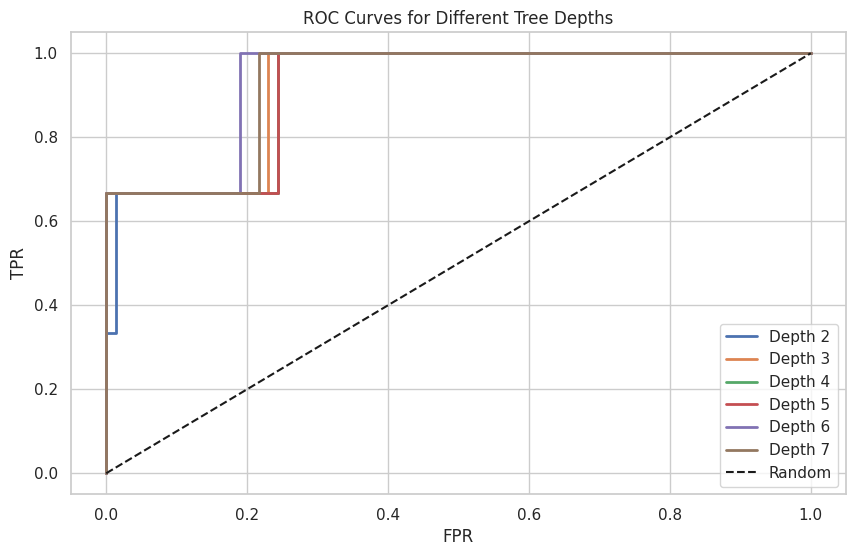

In [15]:
depths = list(range(2, 8))
accuracies = []
roc_curves = []

for depth in depths:
    rf_clf = RandomForestClassifier(n_estimators=500, max_depth=depth, n_jobs=-1, random_state=42)
    rf_clf.fit(X_train, Y_train)

    rf_y_pred = rf_clf.predict(X_test)
    accuracy = accuracy_score(Y_test, rf_y_pred)
    accuracies.append(accuracy)

    rf_y_prob = rf_clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(Y_test, rf_y_prob)
    roc_curves.append((fpr, tpr))

plt.figure(figsize=(10, 6))

# Plot accuracy vs depth
plt.plot(depths, accuracies, marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy vs Tree Depth')
plt.grid(True)
plt.show()

# Plot ROC curves
plt.figure(figsize=(10, 6))
for i, depth in enumerate(depths):
    fpr, tpr = roc_curves[i]
    plt.plot(fpr, tpr, linewidth=2, label=f'Depth {depth}')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curves for Different Tree Depths')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
print("\nAccuracy scores for different tree depths:")
for depth, accuracy in zip(depths, accuracies):
    print(f"Max Depth {depth}: {accuracy:.4f}")

optimal_depth = depths[np.argmax(accuracies)]
print(f"\nOptimal tree depth: {optimal_depth} with accuracy: {max(accuracies):.4f}")


Accuracy scores for different tree depths:
Max Depth 2: 0.9610
Max Depth 3: 0.9610
Max Depth 4: 0.9610
Max Depth 5: 0.9610
Max Depth 6: 0.9740
Max Depth 7: 0.9870

Optimal tree depth: 7 with accuracy: 0.9870


Random Forest is highly stable, with nearly identical accuracy scores. The dataset is quite small, limiting the overall variability and resulting in step-like ROC curves. The ROC curve is above the random guessing line indicating a good model, however the curve doesn't hug the top left corner meaning there is some uncertainty in the predictions.

### While the most optimal tree depth is 7, a tree depth of 2 results in only 2% less accuracy. Therefore, to combat overfitting and leverage the benefits of an ensemble model, the chosen optimal tree depth is 2.

6. For the Adaboost classifier, modify the learning rate to a higher rate and a low rate and analyze and comment on the results (you need to experiment with the learning rate to figure out what range makes sense).

<Figure size 1000x600 with 0 Axes>

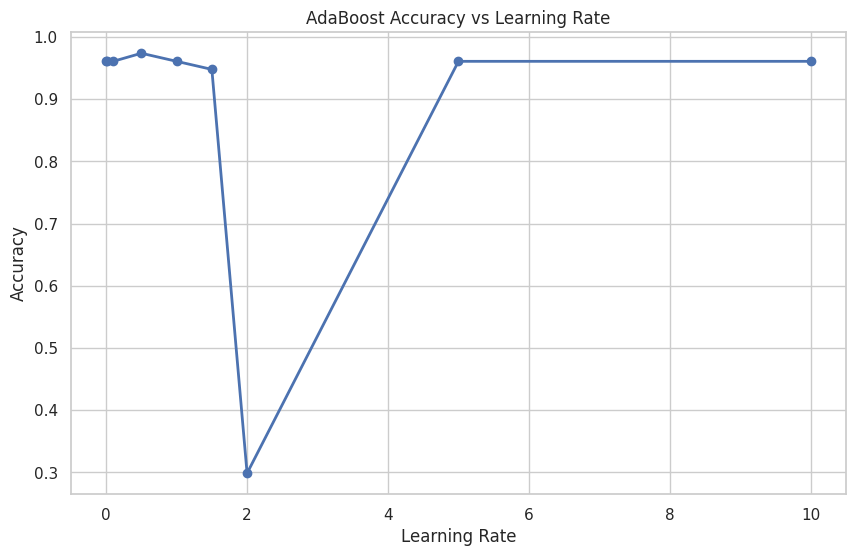

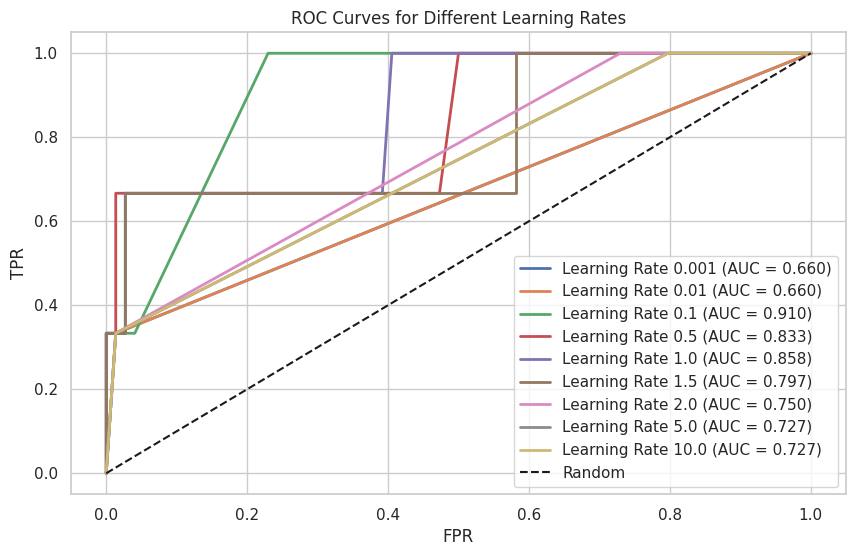

In [17]:
rates = [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0]
accuracies = []
roc_curves = []
auc_scores = []
from sklearn.metrics import roc_auc_score
for rate in rates:
    ab_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, random_state=42), n_estimators=50, learning_rate=rate, random_state=42)
    ab_clf.fit(X_train, Y_train)

    ab_y_pred = ab_clf.predict(X_test)
    accuracy = accuracy_score(Y_test, ab_y_pred)
    accuracies.append(accuracy)

    ab_y_prob = ab_clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(Y_test, ab_y_prob)
    roc_curves.append((fpr, tpr))

    auc = roc_auc_score(Y_test, ab_y_prob)
    auc_scores.append(auc)

plt.figure(figsize=(10, 6))

# Plot accuracy vs depth
plt.figure(figsize=(10, 6))
plt.plot(rates, accuracies, marker='o', linewidth=2)
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('AdaBoost Accuracy vs Learning Rate')
plt.grid(True)
plt.show()

# Plot ROC curves
plt.figure(figsize=(10, 6))
for i, lr in enumerate(rates):
    fpr, tpr = roc_curves[i]
    plt.plot(fpr, tpr, linewidth=2, label=f'Learning Rate {lr} (AUC = {auc_scores[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curves for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
print("\nAccuracy scores for different learning rates:")
for lr, accuracy in zip(rates, accuracies):
    print(f"Learning Rate {lr:.3f}: {accuracy:.4f}")


Accuracy scores for different learning rates:
Learning Rate 0.001: 0.9610
Learning Rate 0.010: 0.9610
Learning Rate 0.100: 0.9610
Learning Rate 0.500: 0.9740
Learning Rate 1.000: 0.9610
Learning Rate 1.500: 0.9481
Learning Rate 2.000: 0.2987
Learning Rate 5.000: 0.9610
Learning Rate 10.000: 0.9610


AdaBoost shows consistent result for varying learning rates. It strongly indicates that the small dataset contains very clear decision boundaries that are easily captured by the AdaBoost classifier, making the learning rate essentially irrelevant for this particular classification task.

### Because of similar accuracies, we evaluate the AUC score to determine the **optimal learning rate of 0.1**. This achieves the highest accuract and highest AUC score of 0.910

### Because most learning rates produce similar accuracies, our dataset may be class imbalanced.

7. Compare the performance of all models (all in steps 2-4) once again this time using cross-validation. Analyze the results and compare with the manual approach (steps 2-4)

In [19]:
def evaluate_each_model_in_turn(models, X, Y):
    results = []
    names = []
    scoring = 'accuracy'
    
    # Perform k-fold validation for each model
    for name, model in models.items():  # Changed from models to models.items()
        kfold = KFold(n_splits=10, random_state=42, shuffle=True)
        cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        print(f"{name}: {cv_results.mean():.4f} (±{cv_results.std()*2:.4f})")
    
    # Create boxplot comparison
    plt.figure(figsize=(10, 6))
    plt.boxplot(results, labels=names)
    plt.title('Cross-Validation Model Comparison')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return dict(zip(names, [{'mean': r.mean(), 'std': r.std()} for r in results]))

Bagging: 0.9554 (±0.0669)
Decision Tree: 0.8926 (±0.0866)
Random Forest: 0.9476 (±0.0667)
AdaBoost: 0.8899 (±0.0665)


/tmp/ipykernel_13824/3925844111.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results, labels=names)


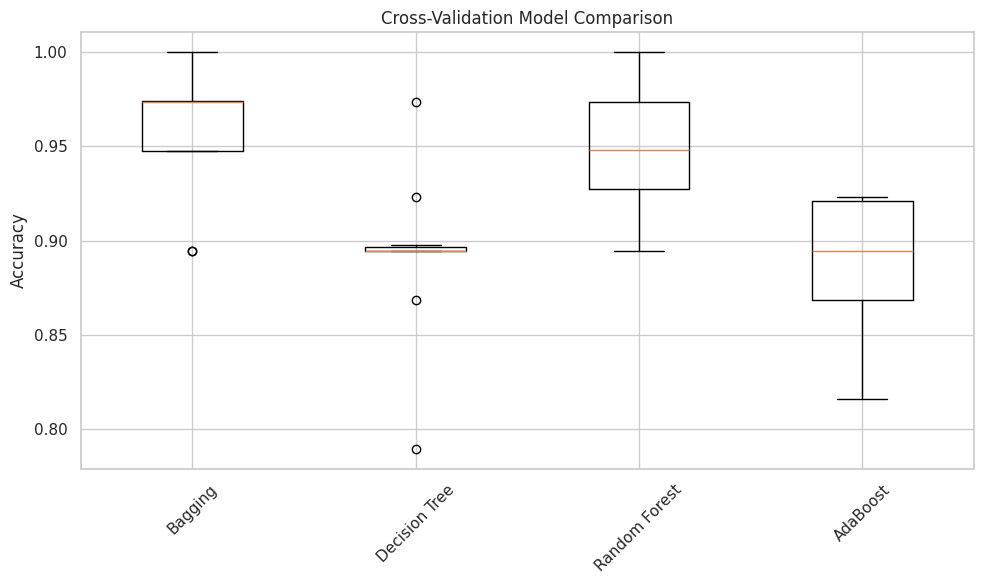


Comparison with previous non-CV results:
               Non-CV Accuracy  CV Mean Accuracy  CV Std Dev
Decision Tree           0.9091            0.8926      0.0433
Bagging                 0.9610            0.9554      0.0335
Random Forest           0.9740            0.9476      0.0333
AdaBoost                0.8961            0.8899      0.0333


In [20]:
models = models_to_compare_in_step_7

# Use the function with your existing classifiers
cv_results = evaluate_each_model_in_turn(models, X, Y)

# Compare with previous non-CV results
comparison_df = pd.DataFrame({
    'Non-CV Accuracy': {
        'Decision Tree': dt_accuracy,
        'Bagging': bag_accuracy,
        'Random Forest': rf_accuracy,
        'AdaBoost': ab_accuracy
    },
    'CV Mean Accuracy': {name: results['mean'] for name, results in cv_results.items()},
    'CV Std Dev': {name: results['std'] for name, results in cv_results.items()}
})

print("\nComparison with previous non-CV results:")
print(comparison_df.round(4))

# EDA Overview:
    - Non-categorical or numeric data was omitted.
    - Log transformation applied to funding amounts to address right-skewed distribution.
    - Years of operation dervices from operation years, untransformed (normally distributed).
    - Sector was one-hot encoded as an input variable.
    - Most features have little to no correlation and the correlation values range from -0.2 to 0.36, indicating most features are not linearally correlated.

# Output variable selection
    - Overhype was chosen due to it's predicability and business relevance.
    - Due to the limited count of Overhyped startups, the models were able to accuraty determine patterns which lead to Overhype.
    - A heatmap is produced to show performance of our models on various output variables, confirming those with small counts in the data are better suited to be predicted, whereas those with many counts, like Giants, are hard to accurately predict.

# Model Analysis
    - Random Forest performed the best with a 97.4% accuracy, confirmed with the highest CV of 94.8%
    - Cross-validation confirmed bagging classifiers, decisiontrees, and adaboost performed strongly
    - Increasing depth of Random Forest to 7 did not produce significantly greater accuracy
    - ROC curve and AUC score were beneficial in determining AdaBoost learning rate as similar accuracies were achieved. Similar accuracies suggest similar decision splits throughout the data, incicating clear categories.
    - Low standard deviations of CV (3.3-4.3%) indicate stable model performance (low variability)